In [2]:
import os

import pandas as pd
import math
import numpy as np
from matplotlib import pyplot as plt
from numpy import logical_and as land, logical_or as lor
import seaborn as sn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mode
from scipy.cluster.hierarchy import linkage, dendrogram
from itertools import combinations

from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = '/content/drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DATA_PATH = 'G:/Shared drives/DM_tweets/data/'

In [5]:
DATA_PATH = 'G:/Drive condivisi/DM_tweets/data/'

In [4]:
df_indicators = pd.read_csv(DATA_PATH+'indicators_clean.csv', sep='#')
#df_tweets_ind = pd.read_csv(DATA_PATH+'tweets_with_indicators.csv', sep='#')
df_users = pd.read_csv(DATA_PATH+'users_clean.csv', sep='#')

In [5]:
def scatterplot(df, attr1, attr2, c_labels, centroids=None, filename=None):
  #cent = scaler.inverse_transform(kmeans.cluster_centers_)
  plt.scatter(df[attr1], df[attr2], c=c_labels)

  if centroids is not None:
    plt.scatter(centroids[:, 0], centroids[:, 1], s=100, marker='.', c='r')

  plt.tick_params(axis='both', which='major')
  if filename!=None:
    plt.savefig(filename)
  else:
    plt.show()


In [40]:
def get_metrics(data_scaled, labels):
  print(f"Silouhette score: {metrics.silhouette_score(data_scaled, labels)}") # [-1, 1] Good when near 1
  print(f"Davies Bouldin score: {metrics.davies_bouldin_score(data_scaled, labels)}") # Good when near 0

In [7]:
df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140543 entries, 0 to 140542
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              140543 non-null  object 
 1   2012_tweets          140543 non-null  int64  
 2   2013_tweets          140543 non-null  int64  
 3   2014_tweets          140543 non-null  int64  
 4   2015_tweets          140543 non-null  int64  
 5   2016_tweets          140543 non-null  int64  
 6   2017_tweets          140543 non-null  int64  
 7   2018_tweets          140543 non-null  int64  
 8   2019_tweets          140543 non-null  int64  
 9   2020_tweets          140543 non-null  int64  
 10  mean_length          140543 non-null  float64
 11  retweets_count_mean  140543 non-null  float64
 12  retweets_count_std   13781 non-null   float64
 13  reply_count_mean     140543 non-null  float64
 14  favorite_count_mean  140543 non-null  float64
 15  num_hashtags_mean

In [8]:
df_users.id = df_users.id.astype(str)
df_merge = df_users.merge(df_indicators, left_on='id', right_on='user_id', how='left')

In [9]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   11508 non-null  object 
 1   name                 11507 non-null  object 
 2   lang                 11508 non-null  object 
 3   bot                  11508 non-null  int64  
 4   created_at           11508 non-null  object 
 5   statuses_count       11508 non-null  float64
 6   created_at_conv      11508 non-null  int64  
 7   user_id              11504 non-null  object 
 8   2012_tweets          11504 non-null  float64
 9   2013_tweets          11504 non-null  float64
 10  2014_tweets          11504 non-null  float64
 11  2015_tweets          11504 non-null  float64
 12  2016_tweets          11504 non-null  float64
 13  2017_tweets          11504 non-null  float64
 14  2018_tweets          11504 non-null  float64
 15  2019_tweets          11504 non-null 

Drop categorical columns

In [10]:
df_merge.drop(columns=['id', 'user_id', 'name', 'lang', 'created_at', 'bot'], inplace=True)
#df_merge.drop(columns=[str(y)+'_tweets' for y in range(2012,2021)], inplace=True)

In [11]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   statuses_count       11508 non-null  float64
 1   created_at_conv      11508 non-null  int64  
 2   2012_tweets          11504 non-null  float64
 3   2013_tweets          11504 non-null  float64
 4   2014_tweets          11504 non-null  float64
 5   2015_tweets          11504 non-null  float64
 6   2016_tweets          11504 non-null  float64
 7   2017_tweets          11504 non-null  float64
 8   2018_tweets          11504 non-null  float64
 9   2019_tweets          11504 non-null  float64
 10  2020_tweets          11504 non-null  float64
 11  mean_length          11504 non-null  float64
 12  retweets_count_mean  11504 non-null  float64
 13  retweets_count_std   11394 non-null  float64
 14  reply_count_mean     11504 non-null  float64
 15  favorite_count_mean  11504 non-null 

In [12]:
# Replace NaN values in variance with 0 
# (NaN values are given when the user only has one tweet so it is safe to assume variance can be 0)

df_merge = df_merge.fillna(value=0)
#df_merge.drop(columns=['created_at_conv', 'created_at_mean'], inplace=True)

# Normalization of values

In [13]:
def to_log(df, attr):
  df[attr] = np.log(df[attr].values)
  df[attr] = df[attr].replace(-np.inf, 0)
  df[attr] = df[attr].fillna(value = 0)
  return df[attr]

It is possible to see that our data has very different ranges of values for different attributes going from ranges from 0 to hundreds and from 0 to hundred thousands. This means that it would be best to normalize the values either in a range [0, 1] or in logscale.

In [14]:
for attr in df_merge.columns:
  print(attr)
  print(df_merge[attr].max())
  print(df_merge[attr].min())

statuses_count
399555.0
0.0
created_at_conv
1587454111000000000
1327370258000000000
2012_tweets
7.0
0.0
2013_tweets
169.0
0.0
2014_tweets
885.0
0.0
2015_tweets
1697.0
0.0
2016_tweets
2824.0
0.0
2017_tweets
3250.0
0.0
2018_tweets
3202.0
0.0
2019_tweets
3360.0
0.0
2020_tweets
3350.0
0.0
mean_length
245.0
0.0
retweets_count_mean
1.5884102861333332e+18
0.0
retweets_count_std
9.0050224722872e+16
0.0
reply_count_mean
68859.375
0.0
favorite_count_mean
337.63793103448273
0.0
num_hashtags_mean
16921.625
0.0
num_urls_mean
6.294624538366844
0.0
num_mentions_mean
2.0
0.0
created_at_mean
5.433962264150943
0.0
max_daily_tweets
3238.0
0.0


In [15]:
# Log scale
df_merge_log = pd.DataFrame()

for attr in df_merge.columns:
  print(attr)
  df_merge_log[attr] = to_log(df_merge, attr)
  print(df_merge_log[attr].max())
  print(df_merge_log[attr].min())

df_merge_log.info()

statuses_count
12.898106706802647
0.0
created_at_conv
41.90866321880304
41.72973140916386
2012_tweets
1.9459101490553132
0.0
2013_tweets
5.1298987149230735
0.0
2014_tweets
6.785587645007929
0.0
2015_tweets
7.436617265234227
0.0
2016_tweets
7.945909598613133
0.0
2017_tweets
8.086410275323782
0.0
2018_tweets
8.07153089355666
0.0
2019_tweets
8.11969625295725
0.0
2020_tweets
8.116715624819111
0.0
mean_length
5.501258210544727
0.0
retweets_count_mean
41.90926536992957
0.0
retweets_count_std
39.03914396206393
0.0
reply_count_mean
11.139821660464452
-5.204006687076813
favorite_count_mean
5.821974111370417
-4.454347296253515
num_hashtags_mean
9.736347668737777
-5.303304908059086
num_urls_mean
1.839696021296041
-8.103796712981817
num_mentions_mean
0.6931471805599453
-8.104703468371365
created_at_mean
1.6926685665838241
-8.11102783819392
max_daily_tweets
8.08271113423758
0.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 21 columns):
 #   Column  

C:\Users\al\AppData\Local\Temp\ipykernel_20200\3892191616.py:2: RuntimeWarning: divide by zero encountered in log
  df[attr] = np.log(df[attr].values)
C:\Users\al\AppData\Local\Temp\ipykernel_20200\3892191616.py:2: RuntimeWarning: divide by zero encountered in log
  df[attr] = np.log(df[attr].values)
C:\Users\al\AppData\Local\Temp\ipykernel_20200\3892191616.py:2: RuntimeWarning: divide by zero encountered in log
  df[attr] = np.log(df[attr].values)
C:\Users\al\AppData\Local\Temp\ipykernel_20200\3892191616.py:2: RuntimeWarning: divide by zero encountered in log
  df[attr] = np.log(df[attr].values)
C:\Users\al\AppData\Local\Temp\ipykernel_20200\3892191616.py:2: RuntimeWarning: divide by zero encountered in log
  df[attr] = np.log(df[attr].values)
C:\Users\al\AppData\Local\Temp\ipykernel_20200\3892191616.py:2: RuntimeWarning: divide by zero encountered in log
  df[attr] = np.log(df[attr].values)
C:\Users\al\AppData\Local\Temp\ipykernel_20200\3892191616.py:2: RuntimeWarning: divide by zero

In [16]:
# Normalizzare i valori in log
scaler = MinMaxScaler()
scaler.fit(df_merge_log.values)
df_merge_scaled = scaler.transform(df_merge_log.values)

In [17]:
df_merge_scaled

array([[0.33576504, 0.86965463, 0.        , ..., 0.92121403, 0.70251588,
        0.3505276 ],
       [0.30926896, 0.87070574, 0.        , ..., 0.92121403, 0.72270444,
        0.35759929],
       [0.08517624, 0.41769469, 0.        , ..., 0.92121403, 0.82734384,
        0.08575677],
       ...,
       [0.13891647, 0.40702063, 0.        , ..., 0.87512719, 0.71528281,
        0.08575677],
       [0.28978436, 0.87536926, 0.        , ..., 0.92121403, 0.73388004,
        0.28487782],
       [0.66455428, 0.72144027, 0.        , ..., 0.43413246, 0.7994869 ,
        0.64178785]])

# DB Scan

In [68]:
dist = pdist(df_merge_scaled, 'euclidean')
dist_matrix = squareform(dist)

In [69]:
distances = list()

for d in dist_matrix:
  index_kth_distance = np.argsort(d)[k]
  distances.append(d[index_kth_distance])

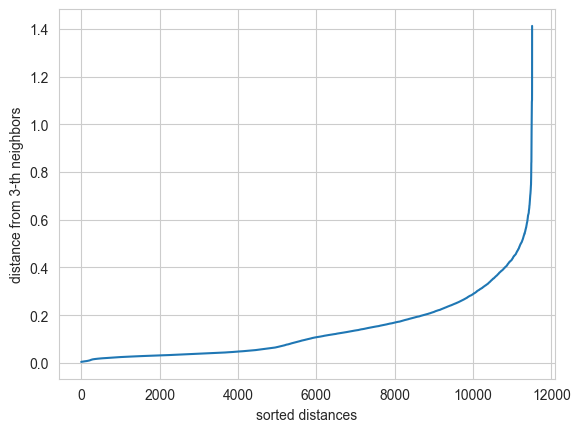

In [70]:
plt.plot(range(0, len(distances)), sorted(distances))
plt.ylabel('distance from %s-th neighbors' % 3)
plt.xlabel('sorted distances')
plt.show()

The knee of the curve is around 0.3, so values around this point will be investigated

In [64]:
for eps in [0.28, 0.29, 0.3, 0.31, 0.32]:
  dbscan = DBSCAN(eps=eps, min_samples=42)
  clusters = dbscan.fit(df_merge_scaled)
  print(f"{'-'*10}eps={eps}")
  get_metrics(df_merge_scaled, dbscan.labels_)

----------eps=0.28
Silouhette score: 0.38708113164324115
Davies Bouldin score: 1.3078924256547084
----------eps=0.29
Silouhette score: 0.41224775268875646
Davies Bouldin score: 1.2425175105840007
----------eps=0.3
Silouhette score: 0.41545129592994107
Davies Bouldin score: 1.2521401879980585
----------eps=0.31
Silouhette score: 0.380283411590873
Davies Bouldin score: 1.2771945879577482
----------eps=0.32
Silouhette score: 0.41977133528633276
Davies Bouldin score: 1.2739316140309027


In [65]:
dbscan = DBSCAN(eps=0.29, min_samples=42)
clusters = dbscan.fit(df_merge_scaled)

In [66]:
len(np.unique(clusters.labels_))

12

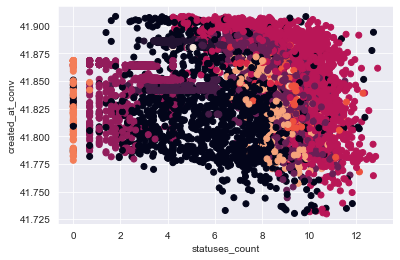

In [67]:
plt.ylabel('created_at_conv')
plt.xlabel('statuses_count')
scatterplot(df_merge_log,'statuses_count', 'created_at_conv', dbscan.labels_)

In [68]:
clusters.components_.shape

(8910, 21)

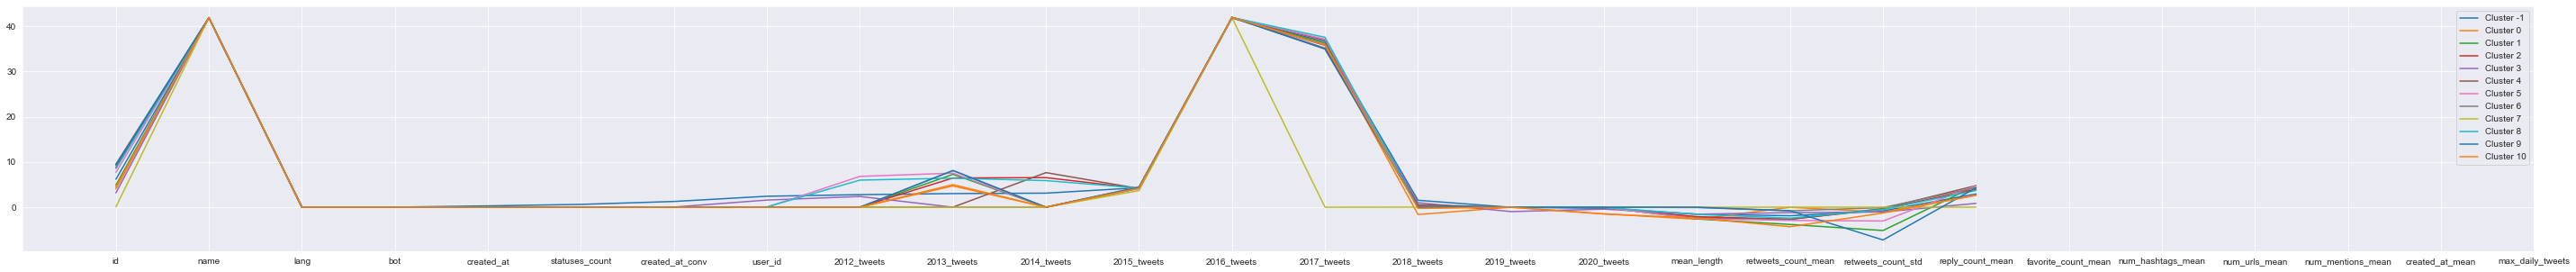

In [69]:
plt.figure(figsize=(50,5))
for label in np.unique(clusters.labels_):
  cent = df_merge_log.loc[np.where(clusters.labels_ == label)].mean()
  plt.plot(cent, label="Cluster %s" % label)
plt.tick_params(axis='both', which='major')
plt.xticks(range(0, len(df_merge.columns)), df_merge.columns)
plt.legend()
plt.show()

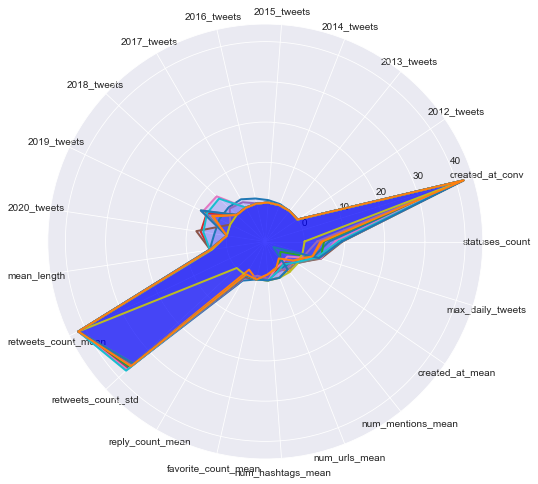

In [70]:
N = len(df_merge_log.columns)

plt.figure(figsize=(8,8))
for label in np.unique(clusters.labels_):
  angles = [n / float(N)*2*math.pi for n in range(N)]
  values = df_merge_log.loc[np.where(clusters.labels_ == label)].mean().tolist()
  values += values[:1]
  angles += angles[:1]

  ax = plt.subplot(polar=True)
  plt.xticks(angles[:-1], df_merge_log.columns)
  ax.plot(angles, values, linewidth=2)
  ax.fill(angles, values, 'b', alpha=0.1)

In [71]:
# Re-initialize Categorical features
df_users.id = df_users.id.astype(str)
df_merge = df_users.merge(df_indicators, left_on='id', right_on='user_id', how='left')


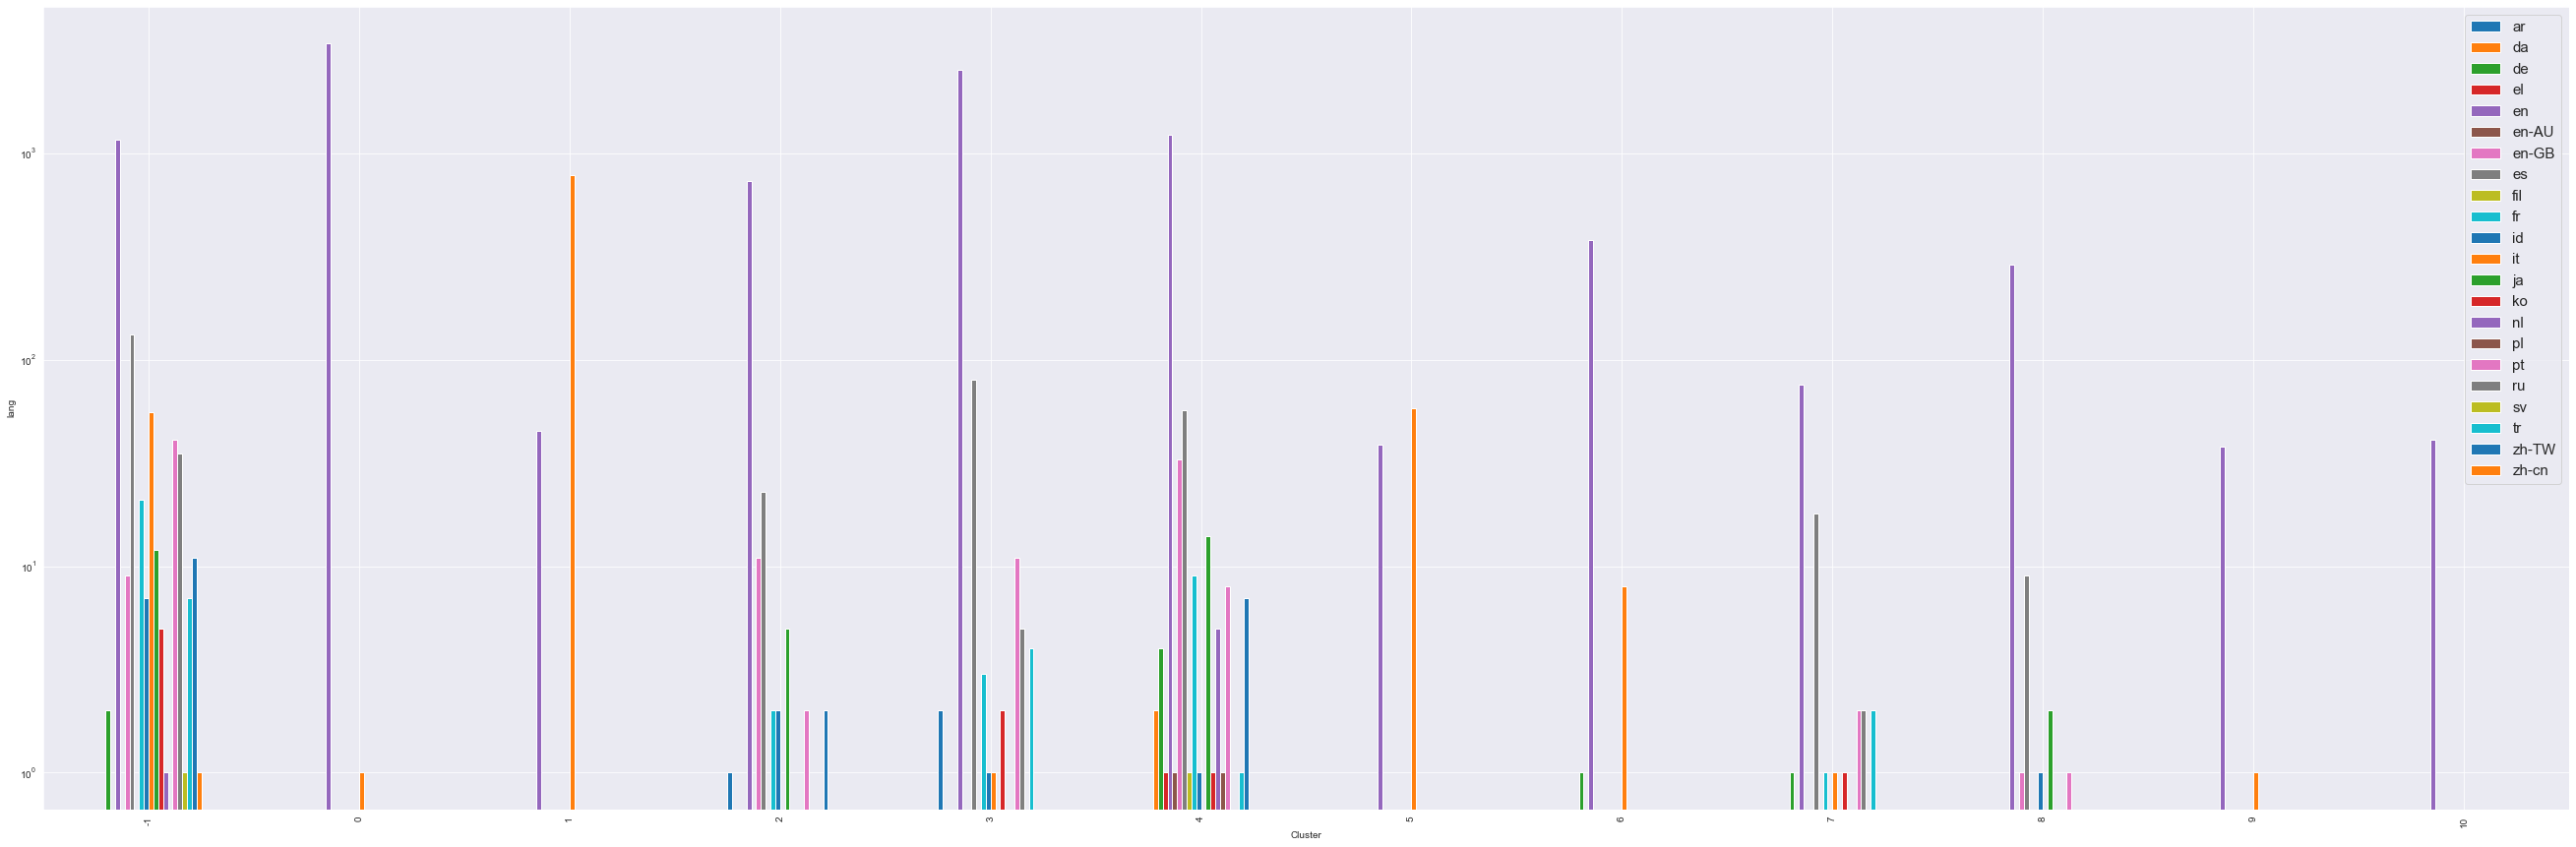

In [72]:
lang_ct = pd.crosstab(clusters.labels_, df_merge['lang'])

fig, ax = plt.subplots(figsize=(46,15))
#plt.figure(figsize=(10,25))
lang_ct.plot(kind='bar', stacked = False, ax=ax)
plt.xlabel('Cluster')
plt.ylabel('lang')
plt.yscale('log')
plt.legend(prop={'size': 15})
plt.show()

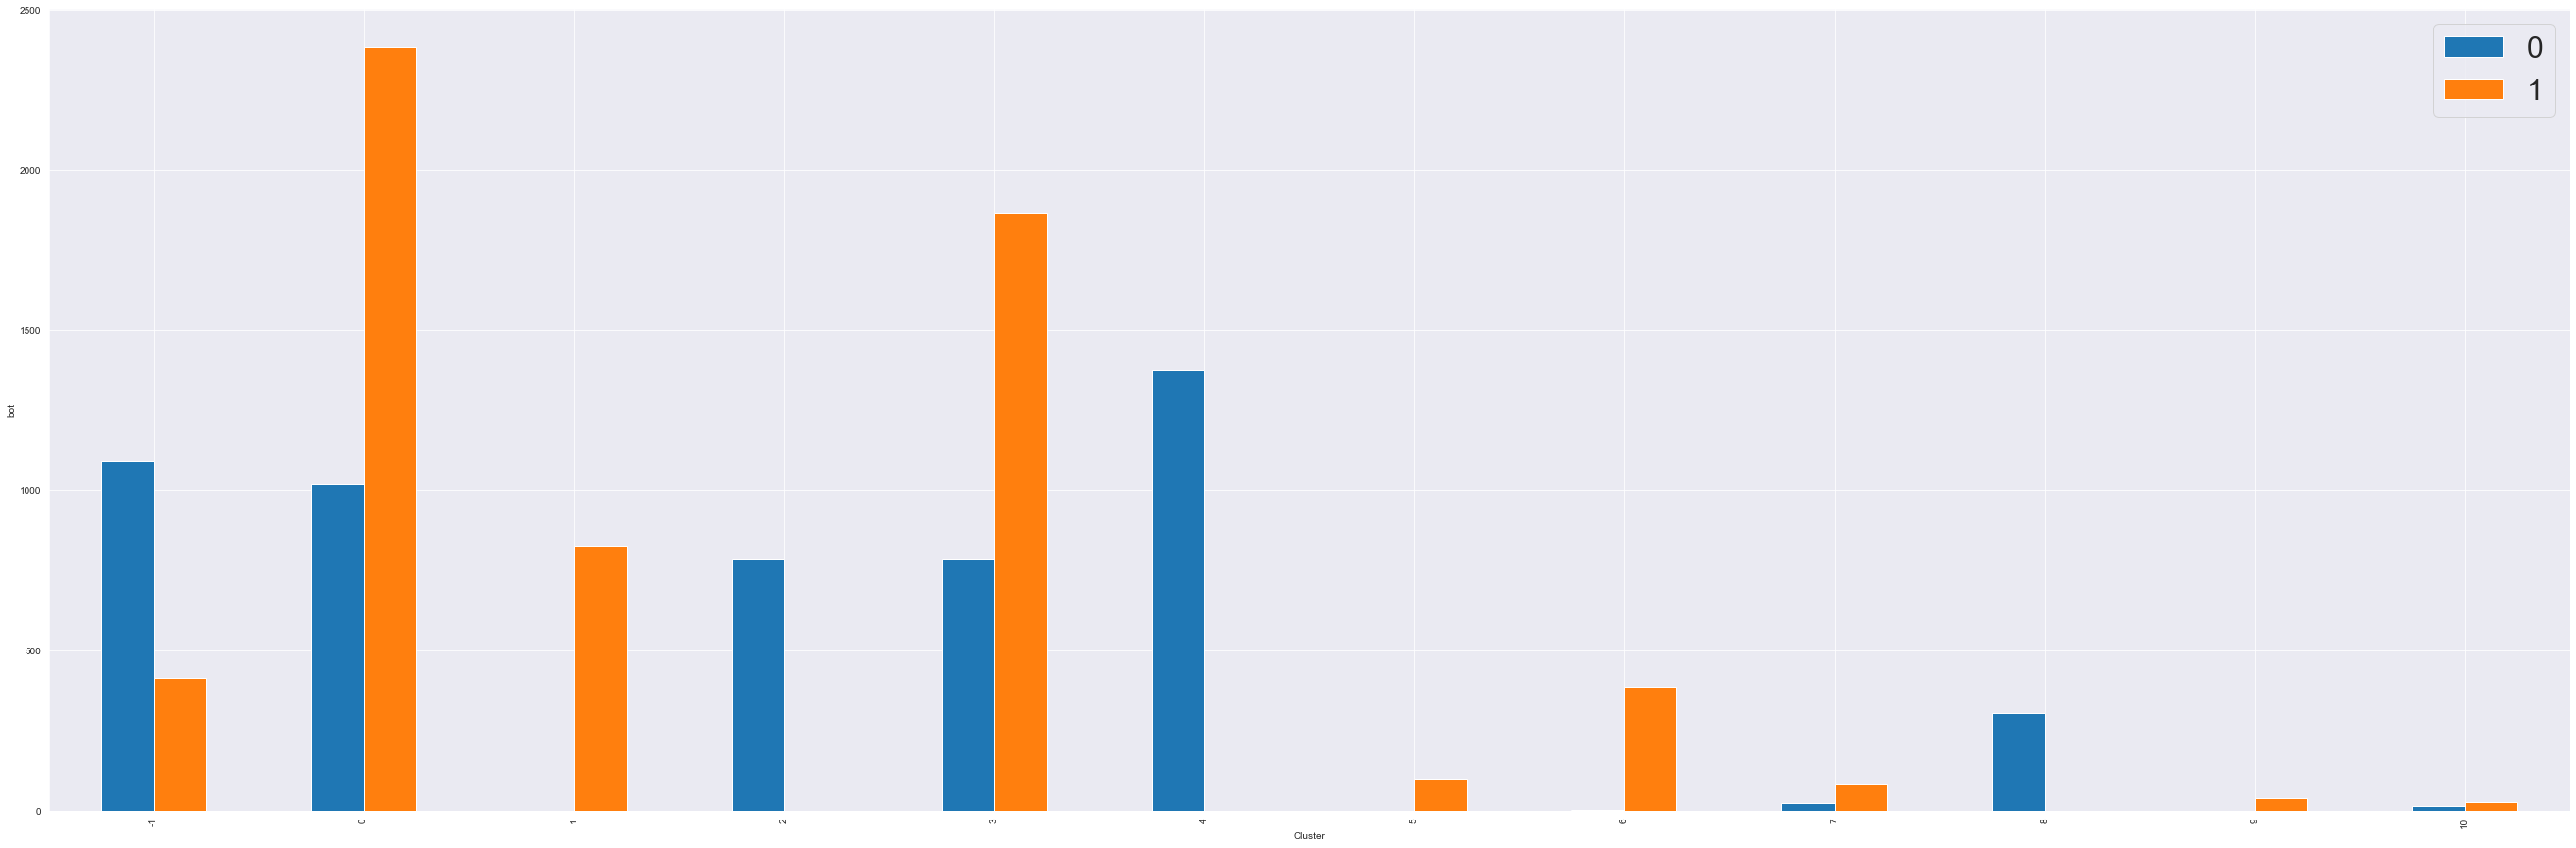

In [73]:
bot_ct = pd.crosstab(clusters.labels_, df_merge['bot'])

fig, ax = plt.subplots(figsize=(46,15))         # Sample figsize in inches
#plt.figure(figsize=(10,25))
bot_ct.plot(kind='bar', stacked = False, ax=ax)
plt.xlabel('Cluster')
plt.ylabel('bot')
plt.legend(prop={'size': 30})
plt.show()

# KMeans

K means is run in two ways: with the complete set of users and removing the samples identified as noisy by DBscan

In [74]:
def find_optimal_k(df, max_k=40):
  sse_list = list()

  for k in range(2, max_k+1):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300)
    kmeans.fit(df)
    sse_list.append(kmeans.inertia_)

  plt.plot(range(2, len(sse_list)+2), sse_list)
  plt.xlabel('Number of clusters')
  plt.ylabel('SSE')
  plt.show()

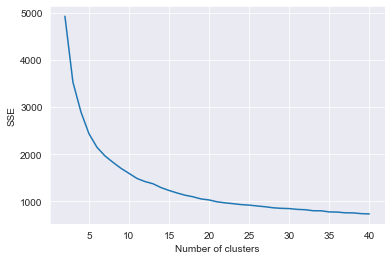

In [75]:
find_optimal_k(df_merge_scaled)

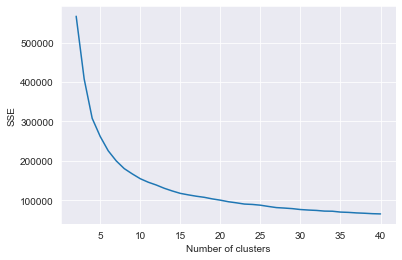

In [76]:
find_optimal_k(df_merge_log)

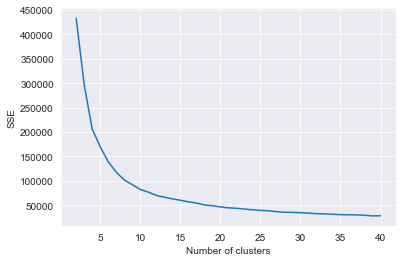

In [77]:
find_optimal_k(df_merge_log[clusters.labels_ != -1])

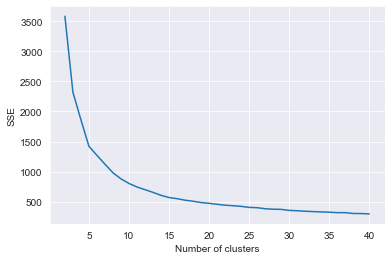

In [78]:
find_optimal_k(df_merge_scaled[clusters.labels_ != -1])

The optimal number of clusters seems to be 7 for the log scaled data, while for the normalized data is 10.

In [124]:
k = 7
kmeans = KMeans(n_clusters = k, n_init=10, max_iter=100)
kmeans.fit(df_merge_log[clusters.labels_ != -1])

KMeans(max_iter=100, n_clusters=7)

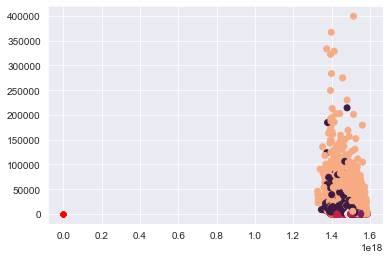

In [127]:
cent = scaler.inverse_transform(kmeans.cluster_centers_)
scatterplot(df_merge[clusters.labels_ != -1], 'created_at_conv','statuses_count',kmeans.labels_, centroids=cent)

statuses_count created_at_conv


ValueError: 'c' argument has 10004 elements, which is inconsistent with 'x' and 'y' with size 10683.

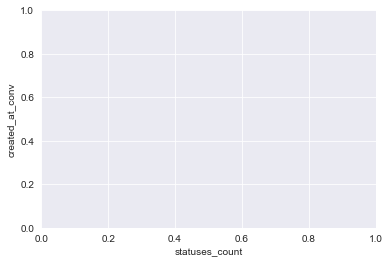

In [128]:
combs= combinations(df_merge_scaled.columns, 2)
for comb in combs:
  plt.ylabel(comb[1])
  plt.xlabel(comb[0])
  print(*comb)
  scatterplot(df_merge[clusters.labels_ != 1], *comb, kmeans.labels_, centroids=cent)

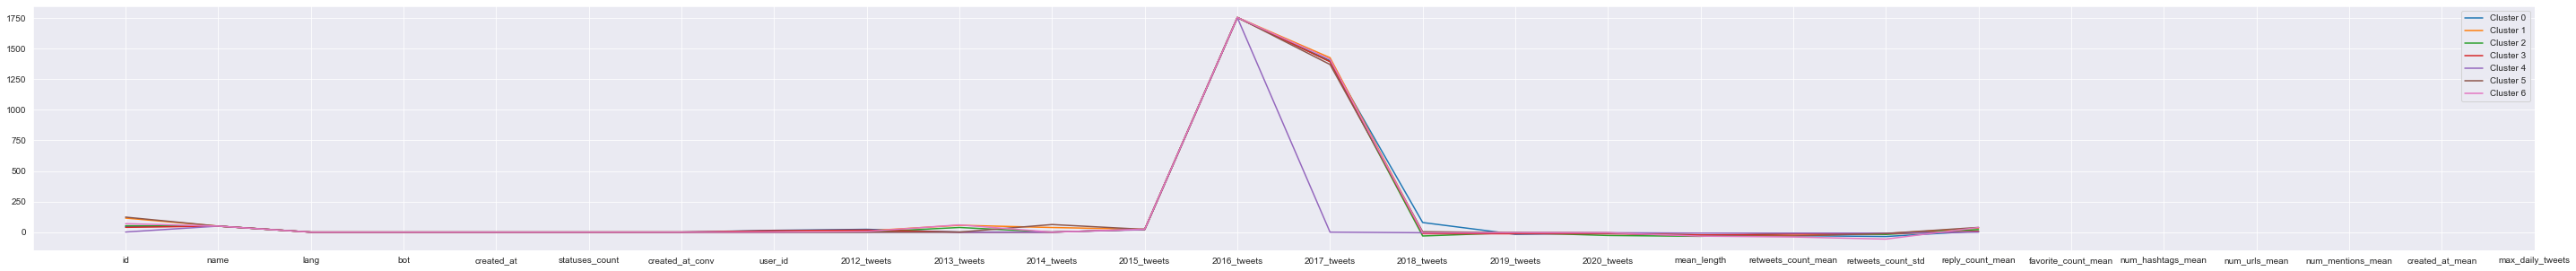

In [129]:
plt.figure(figsize=(50,5))
for i in range(0, len(cent)):
  plt.plot(cent[i], label="Cluster %s" % i)
plt.tick_params(axis='both', which='major')
plt.xticks(range(0, len(df_merge.columns)), df_merge.columns)
plt.legend()
plt.show()

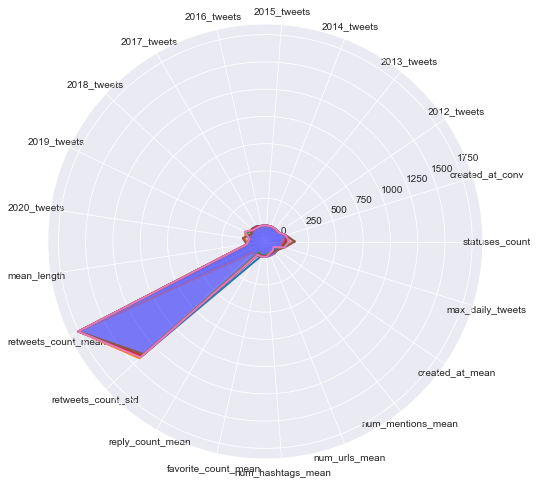

In [130]:
N = len(df_merge_scaled.columns)

plt.figure(figsize=(8,8))
for i in range(0, len(cent)):
  angles = [n / float(N)*2*math.pi for n in range(N)]
  values = cent[i].tolist()
  values += values[:1]
  angles += angles[:1]

  ax = plt.subplot(polar=True)
  plt.xticks(angles[:-1], df_merge_scaled.columns)
  ax.plot(angles, values, linewidth=2)
  ax.fill(angles, values, 'b', alpha=0.1)

In [137]:
get_metrics(df_merge_log[clusters.labels_ != -1], kmeans.labels_)

Silouhette score: 0.46699446120807553
Davies Bouldin score: 0.9010390388525469


In [134]:
# Re-initialize Categorical features
df_users.id = df_users.id.astype(str)
df_merge = df_users.merge(df_indicators, left_on='id', right_on='user_id', how='left')


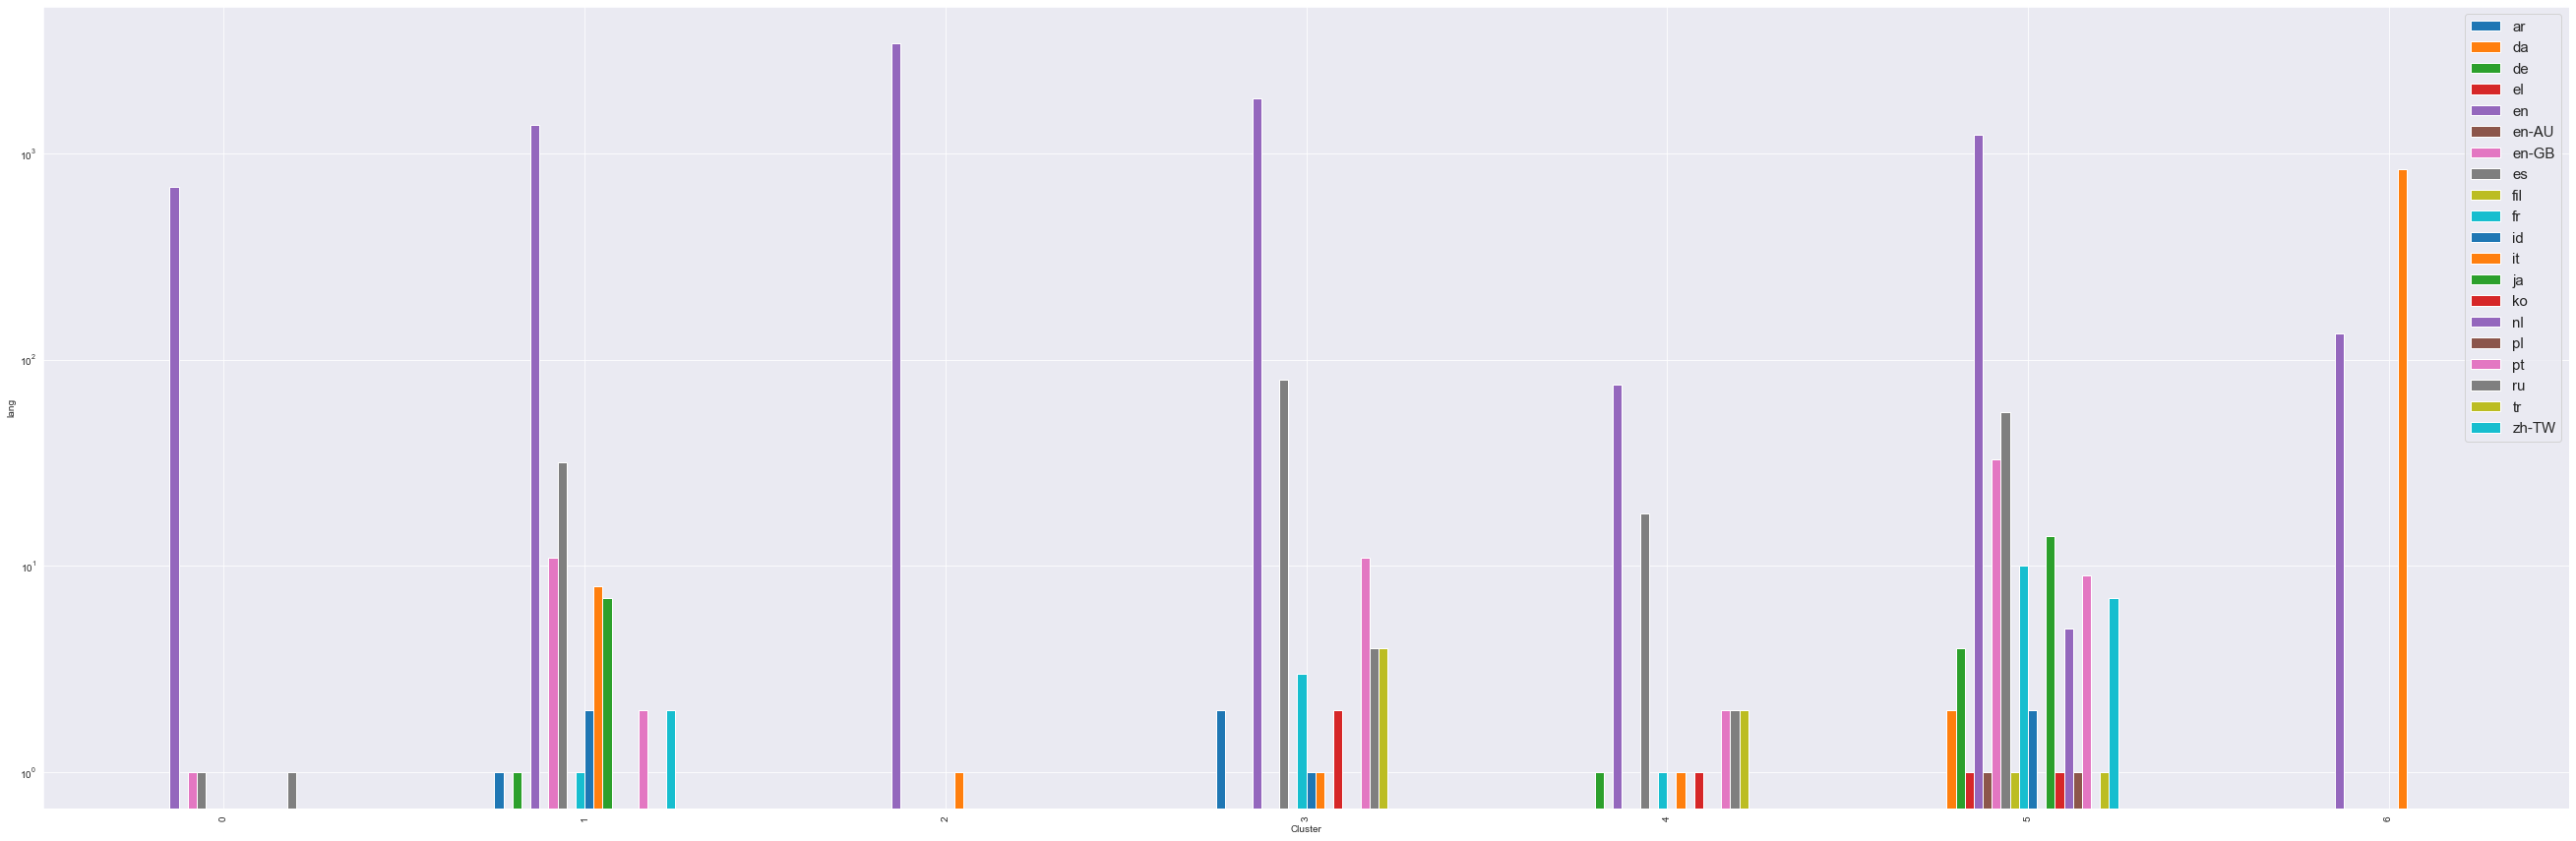

In [138]:
lang_ct = pd.crosstab(kmeans.labels_, df_merge[clusters.labels_!=-1]['lang'])

fig, ax = plt.subplots(figsize=(46,15))
#plt.figure(figsize=(10,25))
lang_ct.plot(kind='bar', stacked = False, ax=ax)
plt.xlabel('Cluster')
plt.ylabel('lang')
plt.yscale('log')
plt.legend(prop={'size': 15})
plt.show()

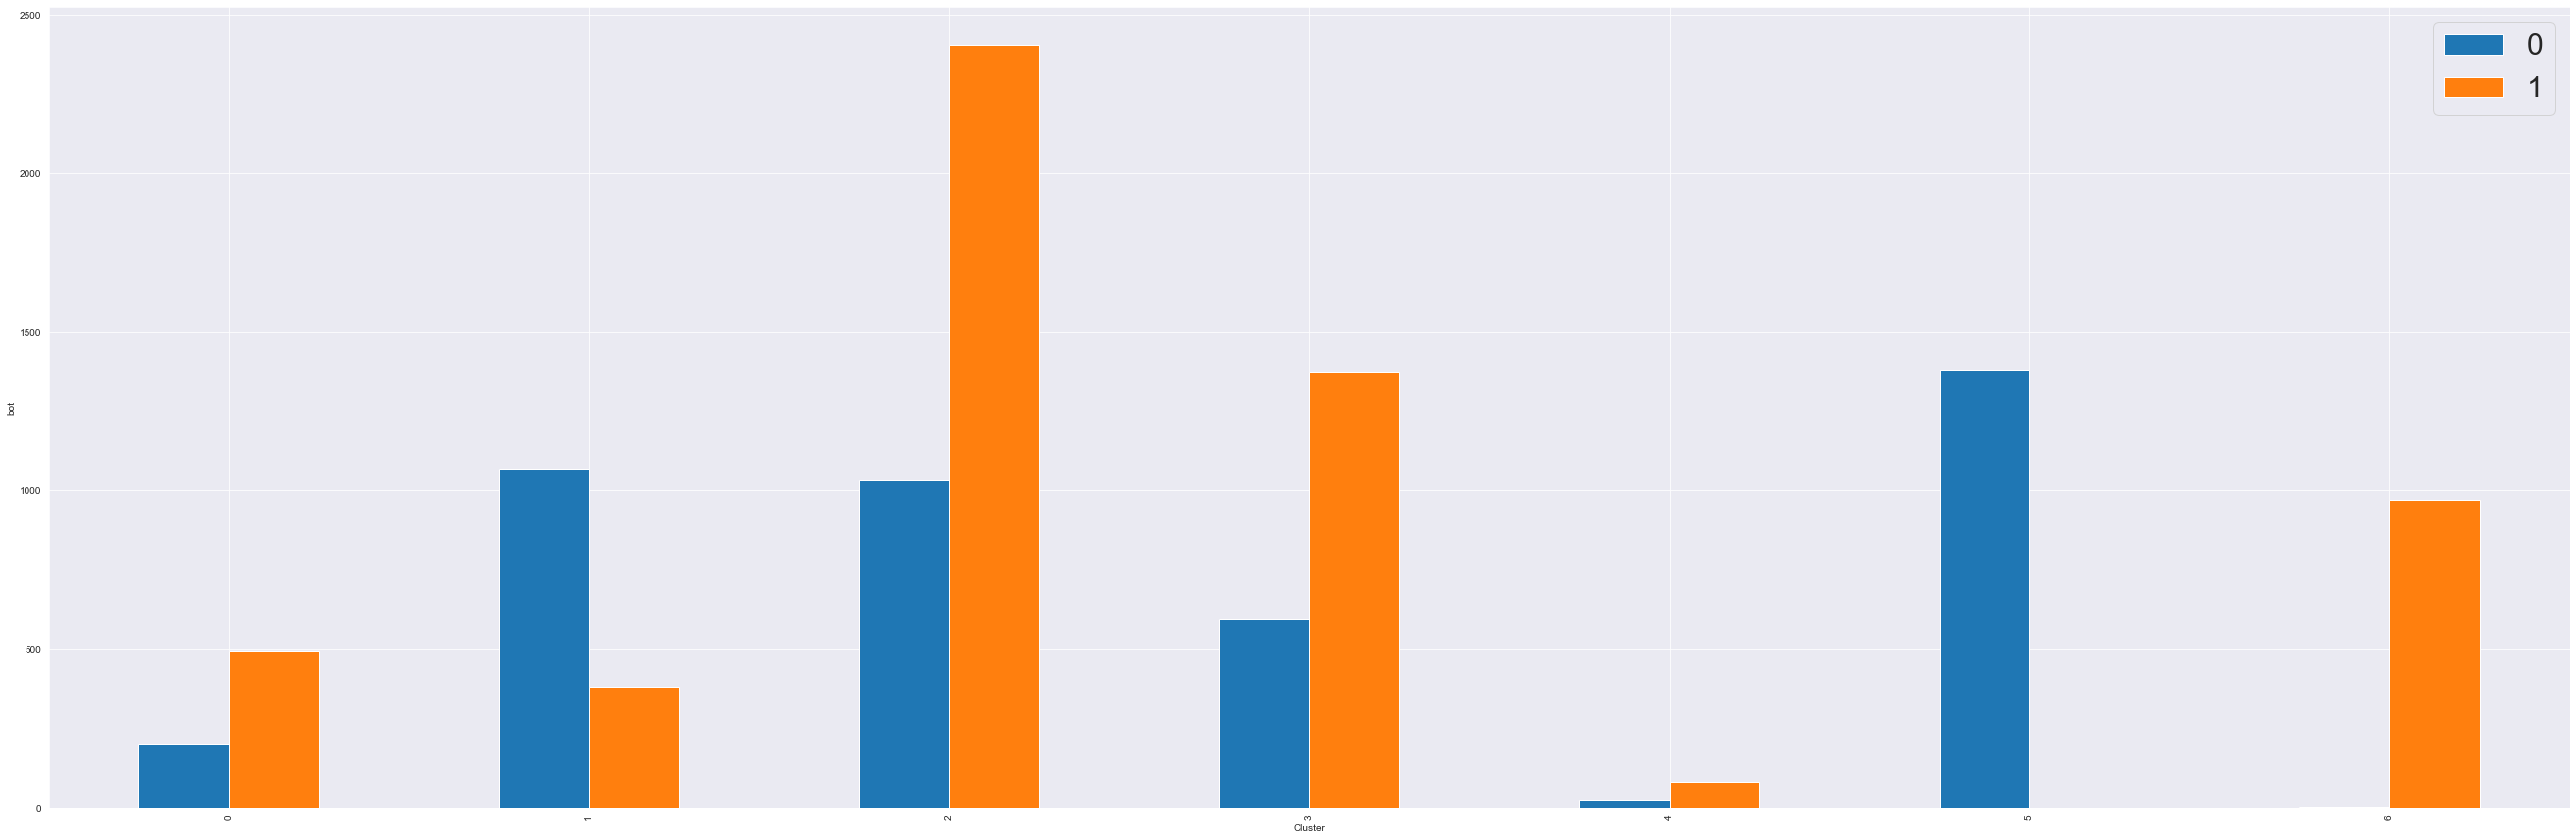

In [141]:
bot_ct = pd.crosstab(kmeans.labels_, df_merge[clusters.labels_!=-1]['bot'])

fig, ax = plt.subplots(figsize=(46,15))         # Sample figsize in inches
#plt.figure(figsize=(10,25))
bot_ct.plot(kind='bar', stacked = False, ax=ax)
plt.xlabel('Cluster')
plt.ylabel('bot')
plt.legend(prop={'size': 30})
plt.show()

# Hierarchical clustering

In [57]:
metric = 'euclidean'
distances = pdist(df_merge_scaled, metric=metric)

In [37]:
dlinkage = linkage(distances, metric=metric, method='complete')

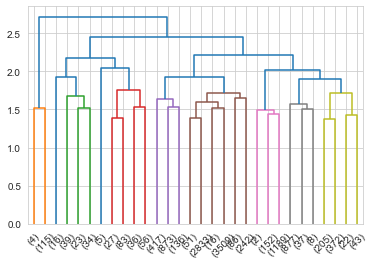

In [38]:
res = dendrogram(dlinkage, truncate_mode='lastp')

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [25.0, 25.0, 42.5, 42.5],
  [75.0, 75.0, 85.0, 85.0],
  [95.0, 95.0, 105.0, 105.0],
  [80.0, 80.0, 100.0, 100.0],
  [65.0, 65.0, 90.0, 90.0],
  [33.75, 33.75, 77.5, 77.5],
  [125.0, 125.0, 135.0, 135.0],
  [115.0, 115.0, 130.0, 130.0],
  [145.0, 145.0, 155.0, 155.0],
  [165.0, 165.0, 175.0, 175.0],
  [150.0, 150.0, 170.0, 170.0],
  [185.0, 185.0, 195.0, 195.0],
  [160.0, 160.0, 190.0, 190.0],
  [122.5, 122.5, 175.0, 175.0],
  [215.0, 215.0, 225.0, 225.0],
  [205.0, 205.0, 220.0, 220.0],
  [245.0, 245.0, 255.0, 255.0],
  [235.0, 235.0, 250.0, 250.0],
  [265.0, 265.0, 275.0, 275.0],
  [285.0, 285.0, 295.0, 295.0],
  [270.0, 270.0, 290.0, 290.0],
  [242.5, 242.5, 280.0, 280.0],
  [212.5, 212.5, 261.25, 261.25],
  [148.75, 148.75, 236.875, 236.875],
  [55.625, 55.625, 192.8125, 192.8125],
  [10.0, 10.0, 124.21875, 124.21875]],
 'dcoord': [[0.0, 1.5189679933506999, 1.5189679933506999, 0.0],
  [0.0,

In [30]:
from sklearn.cluster import AgglomerativeClustering
# non piace alla Naretto perché bisogna scegliere # di clusters
clusters = AgglomerativeClustering(affinity='euclidean', n_clusters=6,  linkage='ward')
clusters.fit(df_merge_scaled)
# or -> clusters.fit_predict(df_merge_scaled)

AgglomerativeClustering(n_clusters=6)

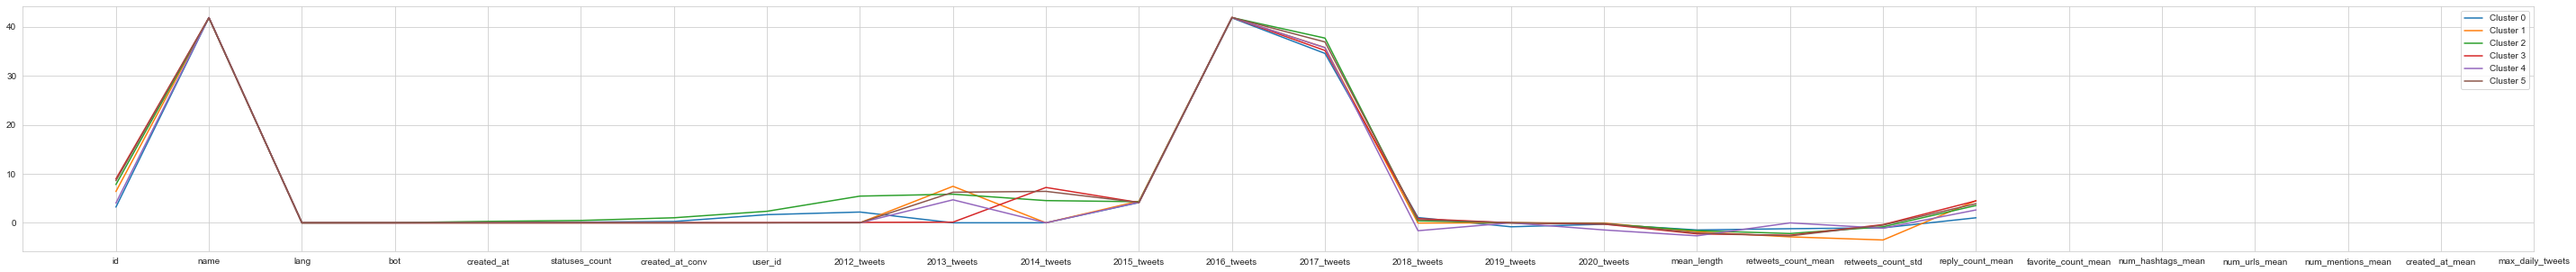

In [31]:
plt.figure(figsize=(50,5))
for label in np.unique(clusters.labels_):
  cent = df_merge_log.loc[np.where(clusters.labels_ == label)].mean()
  plt.plot(cent, label="Cluster %s" % label)
plt.tick_params(axis='both', which='major')
plt.xticks(range(0, len(df_merge.columns)), df_merge.columns)
plt.legend()
plt.show()

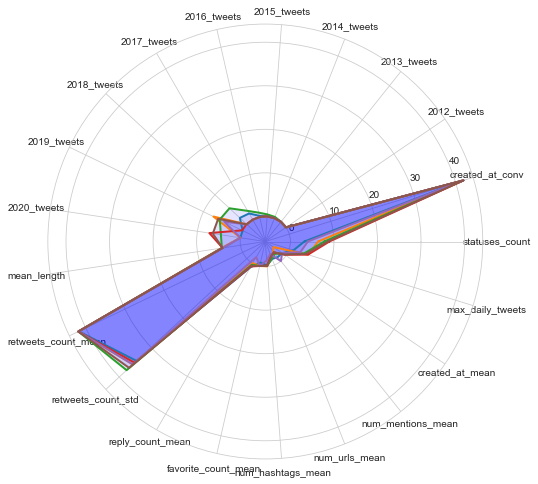

In [32]:
N = len(df_merge_log.columns)

plt.figure(figsize=(8,8))
for label in np.unique(clusters.labels_):
  angles = [n / float(N)*2*math.pi for n in range(N)]
  values = df_merge_log.loc[np.where(clusters.labels_ == label)].mean().tolist()
  values += values[:1]
  angles += angles[:1]

  ax = plt.subplot(polar=True)
  plt.xticks(angles[:-1], df_merge_log.columns)
  ax.plot(angles, values, linewidth=2)
  ax.fill(angles, values, 'b', alpha=0.1)

In [33]:
# Re-initialize Categorical features
df_users.id = df_users.id.astype(str)
df_merge = df_users.merge(df_indicators, left_on='id', right_on='user_id', how='left')


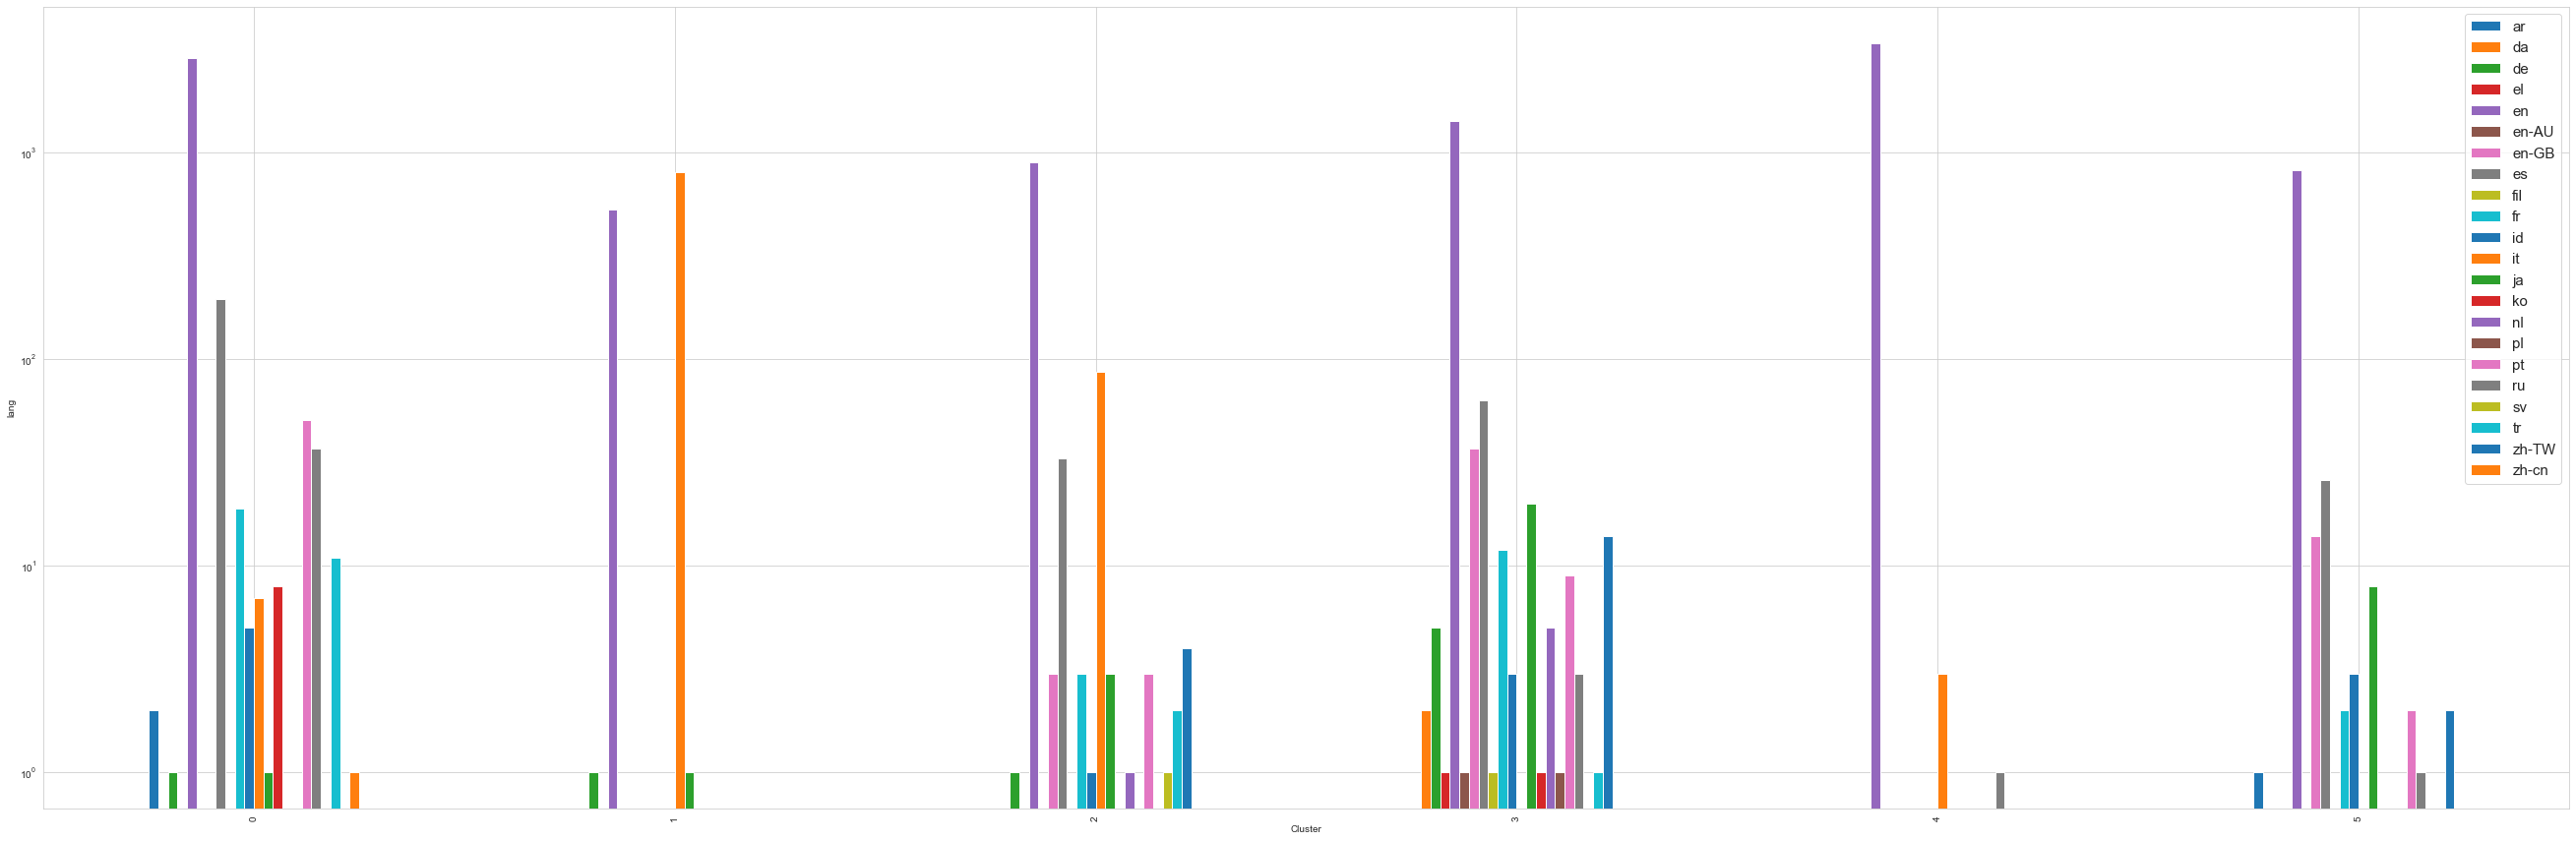

In [34]:
lang_ct = pd.crosstab(clusters.labels_, df_merge['lang'])

fig, ax = plt.subplots(figsize=(46,15))
#plt.figure(figsize=(10,25))
lang_ct.plot(kind='bar', stacked = False, ax=ax)
plt.xlabel('Cluster')
plt.ylabel('lang')
plt.yscale('log')
plt.legend(prop={'size': 15})
plt.show()

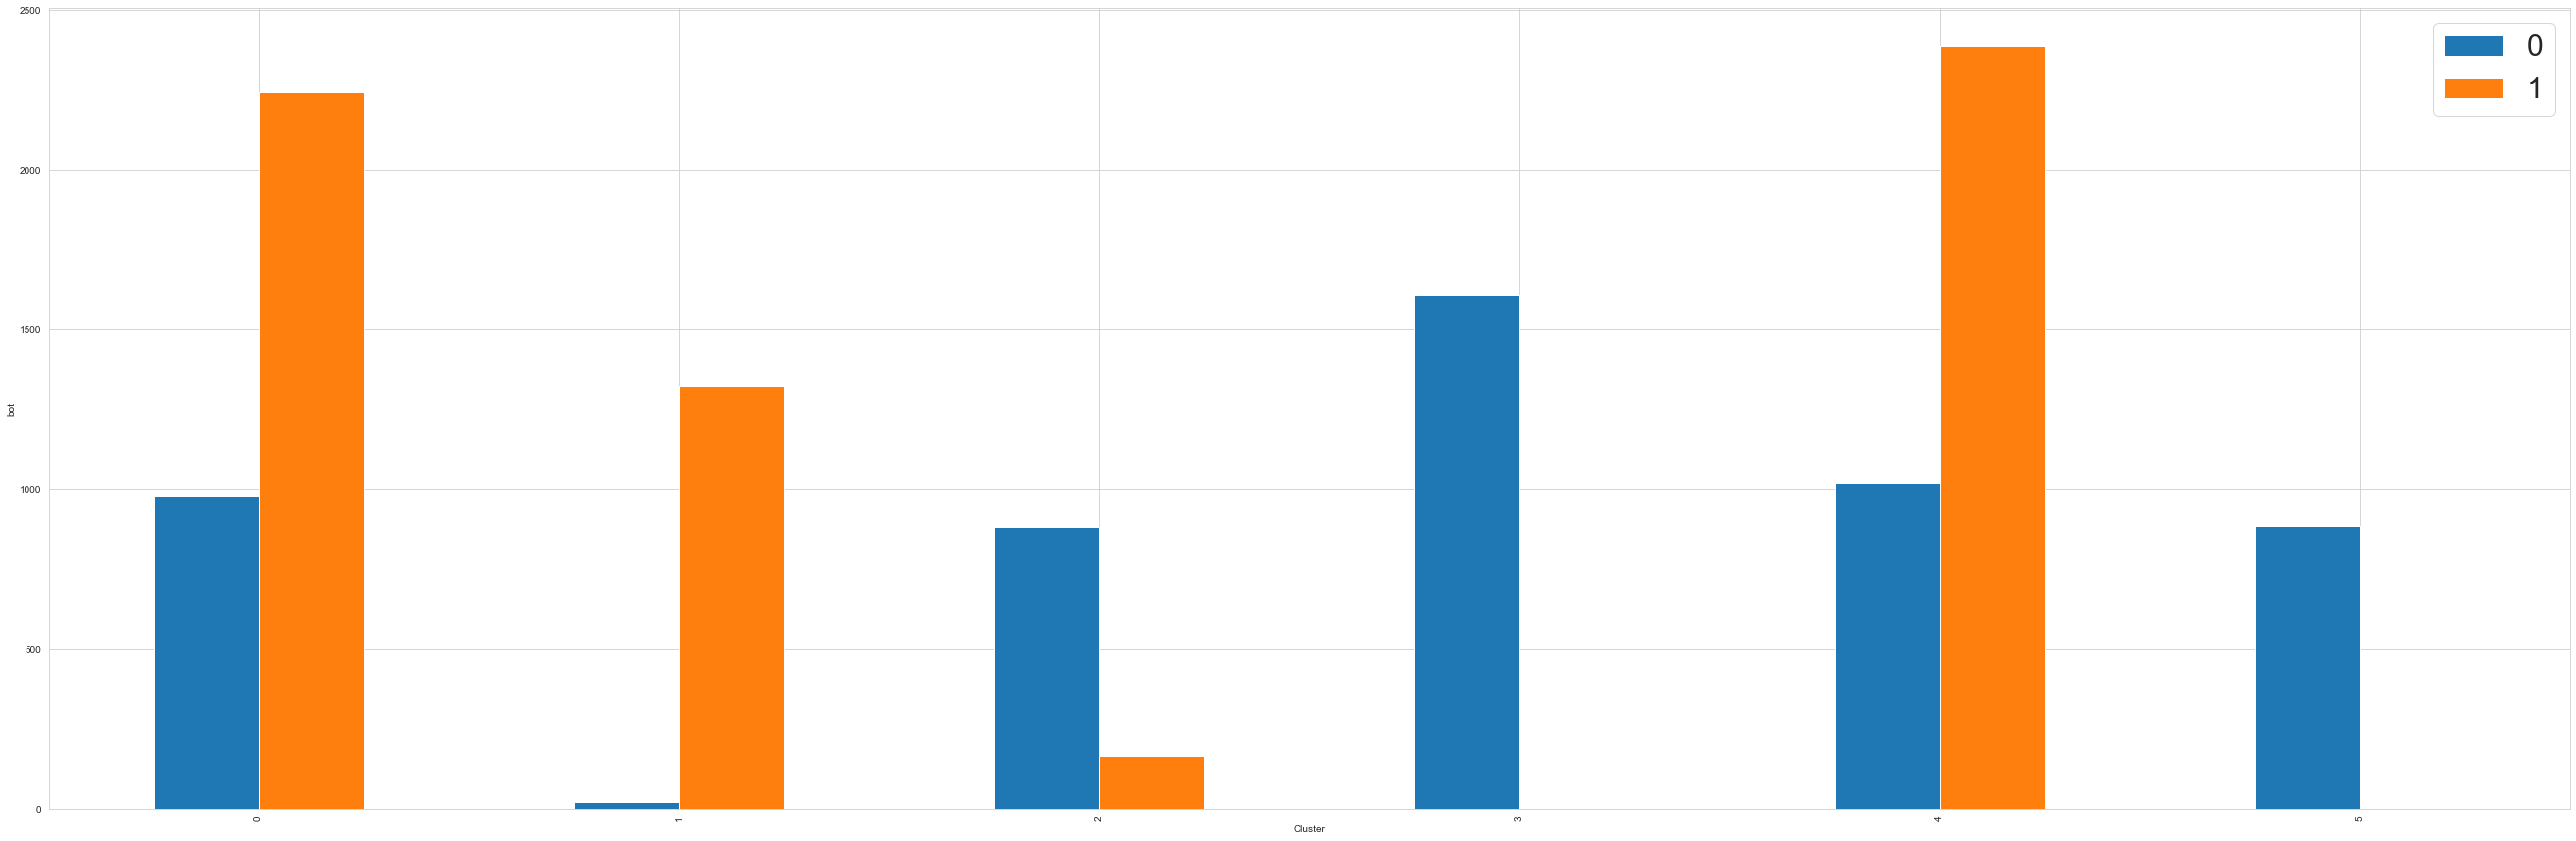

In [35]:
bot_ct = pd.crosstab(clusters.labels_, df_merge['bot'])

fig, ax = plt.subplots(figsize=(46,15))         # Sample figsize in inches
#plt.figure(figsize=(10,25))
bot_ct.plot(kind='bar', stacked = False, ax=ax)
plt.xlabel('Cluster')
plt.ylabel('bot')
plt.legend(prop={'size': 30})
plt.show()